Retrieves images from "raw_imgs" folder and stores them in "full_imgs". Retrieves spreadsheet listing VOIs and stores them in text file.

TODO: function to read existing vois, drop one class, then load the class back in. Requires that drm.load_imgs write to a DataFrame rather than an array

In [1]:
import config
import dr_methods as drm
import helper_fxns as hf
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time
import voi_methods as vm
%matplotlib inline

C:\Users\Clinton\AppData\Local\conda\conda\envs\medical-env\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [51]:
importlib.reload(config)
importlib.reload(hf)
importlib.reload(vm)
importlib.reload(drm)
C = config.Config()

In [19]:
cls="cyst"

In [32]:
acc_num = '12314736'

In [20]:
src_data_df = pd.read_excel(C.xls_name, C.sheetnames[C.cls_names.index(cls)])

In [22]:
src_data_df = drm._filter_voi_df(src_data_df, C)

In [36]:
df_subset

,Patient E Number,x1,x2,y1,y2,z1,z2,Image type,Flipped,x3,...,z3,z4,Image type2,x5,x6,y5,y6,z5,z6,Image type3
20,12314736,66,77,161,171,13,17,AP-T1,NaN,66.0,...,13.0,17.0,VP-T1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,12314736,109,151,82,124,19,39,AP-T1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
voi_df.loc[~voi_df.index.isin(["1_0","1_1"])]

,acc_num,x1
1_2,1,2


In [ ]:
vm.xref_dirs_with_excel()

In [118]:
drm.report_missing_folders()

In [111]:
dims_df = pd.read_csv(C.dims_df_path)
dims_df[dims_df["AccNum"] == "E105927977"]

In [ ]:
drm.dcm2npy_batch(acc_nums=["E105927977"])

In [ ]:
drm.load_vois_batch(cls=None, overwrite=False)

........

# Read Run Stats

In [52]:
import re
import operator

df = pd.read_csv(C.run_stats_path)

df = df.dropna(subset=['misclassified_test'])
df = df.loc[:,['misclassified_test','misclassified_train']]
#df = df.dropna()
#b = a.iloc[0]['y_pred_raw']
#b = hf.str_to_lists(b)

mis_test = df['misclassified_train'].values
#mis_test = df['misclassified_test'].values

mis_test = ''.join(mis_test)
mis_test = mis_test.replace(' ','')
mis_test = mis_test.replace("'","")
mis_test = re.sub(r'\]\[', ',', mis_test)
mis_test = mis_test.replace("[","")
mis_test = mis_test.replace("]","")

mis_test = mis_test.split(',')

unique, counts = np.unique(mis_test, return_counts=True)

x = dict(zip(unique, counts))

sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
sorted_x

In [14]:
df = pd.read_csv(C.run_stats_path)
df = df[(df['test_num'] == 10) & (~df['time_dist']) & (df['steps_per_epoch'] == 750) & (df['timestamp'] > 1515210355)]

In [21]:
train_acc = [1-x.count("npy")/434 for x in df['misclassified_train'].values]

In [27]:
np.mean(train_acc)

0.9958525345622119

In [112]:
cms = df['confusion_matrix'].values

cms = ''.join(cms)

ret = hf.str_to_lists(cms, dtype=int)

supercm = ret

supercm = [supercm[rownum:rownum+6] for rownum in range(0,len(supercm),6)]

supercm = np.array(supercm)

cm_sum = np.empty((6,6))

for i in range(6):
    for j in range(6):
        cm_sum[i,j] = np.sum(supercm[:,i,j])

for i in range(6):
    for j in range(6):
        print(cm_sum[j,i],end='\t')
    print()

187.0	4.0	1.0	0.0	0.0	11.0	
1.0	180.0	18.0	0.0	10.0	6.0	
3.0	6.0	177.0	3.0	7.0	0.0	
0.0	0.0	1.0	197.0	2.0	0.0	
1.0	2.0	3.0	0.0	181.0	2.0	
8.0	8.0	0.0	0.0	0.0	181.0	


In [29]:
truths = df['y_true'].values
truths = ''.join(truths)
truths = hf.str_to_lists(truths, dtype=int)
truths = np.array(truths)

predictions = df['y_pred_raw'].values
predictions = ''.join(predictions)
predictions = hf.str_to_lists(predictions, dtype=float)
predictions = [predictions[rownum:rownum+60] for rownum in range(0,len(predictions),60)]
predictions = np.array(predictions)

hcc_thresh = []
nonhcc_thresh = []
thresh_dict = {}

for run_num in range(20):
    for lesion_num in range(60):
        if truths[run_num, lesion_num] == C.classes_to_include.index('hcc'):
            hcc_thresh.append(predictions[run_num, lesion_num, 0])
            thresh_dict[predictions[run_num, lesion_num, 0]] = 'hcc'
        else:
            nonhcc_thresh.append(predictions[run_num, lesion_num, 0])
            thresh_dict[predictions[run_num, lesion_num, 0]] = 'non-hcc'

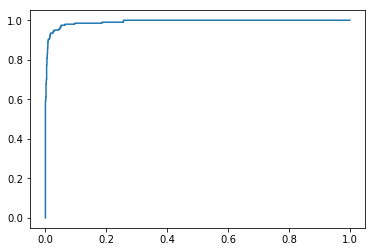

In [31]:
TPR = [200/200]
FPR = [1000/1000]

hcc_correct = 200
hcc_wrong = 1000
for key in sorted(thresh_dict):
    if thresh_dict[key] == 'hcc':
        hcc_correct -= 1
    else:
        hcc_wrong -= 1
    TPR.append(hcc_correct/200)
    FPR.append(hcc_wrong/1000)

plt.plot(FPR, TPR)

In [37]:
AUC = sum([(FPR[i]-FPR[i+1])*TPR[i] for i in range(len(FPR)-1)])
AUC

0.9922300000000035

a = run_stats.loc[:,['y_true','y_pred_raw']]
a = a.dropna()
b = a.iloc[0]['y_pred_raw']
b = hf.str_to_lists(b)

# Reload images and VOIs

In [ ]:
drm.load_vois_all(C)

In [234]:
for cls in C.classes_to_include:
    if not os.path.exists(C.full_img_dir + "\\" + cls):
        os.makedirs(C.full_img_dir + "\\" + cls)
    if not os.path.exists(C.orig_dir + cls):
        os.makedirs(C.orig_dir + cls)
    if not os.path.exists(C.aug_dir + cls):
        os.makedirs(C.aug_dir + cls)
    if not os.path.exists(C.crops_dir + cls):
        os.makedirs(C.crops_dir + cls)

In [ ]:
voi_dfs = init_voi_dfs()

In [ ]:
#
dims_df = pd.read_csv(C.dims_df_path)
voi_df_art = pd.DataFrame(columns = ["Filename", "x1", "x2", "y1", "y2", "z1", "z2", "cls",
                                     "flipz", "real_dx", "real_dy", "real_dz", "id", "lesion_num"])
voi_df_ven = pd.DataFrame(columns = ["id", "x1", "x2", "y1", "y2", "z1", "z2"]) #voi_df_ven only contains entries where manually specified
voi_df_eq = pd.DataFrame(columns = ["id", "x1", "x2", "y1", "y2", "z1", "z2"]) #voi_df_ven only contains entries where manually specified
voi_dfs = [voi_df_art, voi_df_ven, voi_df_eq]

In [119]:
voi_df_art = pd.read_csv(C.art_voi_path)
voi_df_ven = pd.read_csv(C.ven_voi_path)
voi_df_eq = pd.read_csv(C.eq_voi_path)
voi_dfs = [voi_df_art, voi_df_ven, voi_df_eq]
dims_df = pd.read_csv(C.dims_df_path)
intensity_df = pd.read_csv(C.int_df_path)

In [ ]:
intensity_df = drm.get_intensities(C, cls="hemangioma", acc_num='13138944')

In [39]:
a=[56,56,58,74,65,67,69,76,69,75,63,52,68,69,70,68,90,90,70,61,47,65,51,52,53,56,53,71,39,69,69,62,49,71,58,69,52,53,55,37,37,70,39,19,62,69,56,41,43,47,45,44,65,59,26,71,58,49,65,55,72,43,42,36,45,60,65,64,72,59,61,62,63,62,62,31,57,65,67,39,63,62,66,69,65,47,61,54,64,55,55,46,68,68,65,51,63,94,70,76,44,56,62,58,48,70,49,45,45,68,52,64,40,41,56,55,73,53,67,51,34,61,64,49,85,31,67,52,45,48,56,33,48,24,48,42,70,77,76,73,59,60,70,71,64,58,67,33,34,50,49,54,59,60,59,47,48,65,30,67,40,49,44,49,70,82,76,59,52,51,39,60,68,69,50,62,65,72,72,23,59,58,79,68,61,65,41,38,50,50,63,64,59,55,63,68,47,38,61,75,31,73,38,90,62,76,57,52,62,47,77,75,72,77,67,77,66,52,36,33,37,34,56,37,38,59,58,62,52,73,35,64,54,68,52,45,58,59,61,81,44,26,48,54,72,53,81,34,34,66,59,61,69,54,51,51,76,67,52,63,32,63,55,30,50,68,83,64,49,45,59,59,70,70,71,39,39,65,69,65,66,45,45,56,81,76,64,67,64,28,69,50,30,58,71,46,55,30,62,36,55,60,55,54,69,34,63,69,60,56,71,42,22,62,55,51,74,42,69,65,62,56,41,82,48,77,71,70,77,64,43,43,57,46,66,55,54,48]

In [43]:
np.std(a)

13.564124361581149

In [ ]:
patient_info_df = pd.DataFrame(columns = ["MRN", "Sex", "AccNum", "AgeAtImaging", "cls"])
for cls in C.classes_to_include:
    #drm.check_folders(img_dirs[i], xls_name, sheetnames[i], C)
    #dims_df = drm.load_imgs(img_dirs[i], cls_names[i], xls_name, sheetnames[i], dims_df, C)
    #voi_dfs = drm.load_vois_batch(cls_names[i], voi_dfs, dims_df, C)#, acc_nums=['E104764948','E106046622'])
    #intensity_df = drm.get_intensities(C, cls=cls_names[i], acc_num='E106046622')
    patient_info_df = drm.load_patient_info(cls, acc_nums=['12916368'])
    patient_info_df.to_csv('Z:\\patient_info.csv', index=False)

In [187]:
#voi_df_art, voi_df_ven, voi_df_eq = voi_dfs
voi_df_art.to_csv(C.art_voi_path, index=False)
voi_df_ven.to_csv(C.ven_voi_path, index=False)
voi_df_eq.to_csv(C.eq_voi_path, index=False)

In [ ]:
dims_df.to_csv(C.dims_df_path, index=False)

In [13]:
#drm.delete_imgs(['12916368', 'E102556695'], 'hcc', C)
#drm.delete_imgs(0, cls, C, xls_name, sheetname)
drm.load_imgs_batch(["13051264"], "cyst")


Loading DCM for ['13051264']
Found elastix version: 4.800 in 'c:\\program files\\elastix_v4.8\\elastix.exe'
.Overall time: 198.79181838035583


In [ ]:
vm.xref_dirs_with_excel(C)

In [107]:
Z_reader = ['12888679_2.npy', 'E101218384_5.npy', '12324408_0.npy', '12975280_0.npy', 'E100962970_0.npy', 'E101083458_1.npy', 'E105311123_0.npy', 'E104697262_0.npy', 'E100183257_1.npy', 'E103312835_1.npy', '13203550_7.npy', '12207268_0.npy', 'E100610622_0.npy', 'E100718398_0.npy', '12302576_0.npy', '12207268_2.npy', '12530153_0.npy', '13028374_0.npy', '12451831_0.npy', '12569826_0.npy', '12678910_1.npy', '12239783_0.npy', '12842070_0.npy', '12799652_0.npy', '12678910_0.npy', '12823036_0.npy', '11907521_0.npy', 'E100168661_0.npy', '12874178_3.npy', '12788616_0.npy', 'E102093118_0.npy', 'E105310461_0.npy', 'E103200384_1.npy', 'E102634440_0.npy', '12569915_0.npy', 'E102095465_0.npy', 'E102929168_0.npy', 'E102613189_0.npy', 'E103020139_1.npy', '12582632_0.npy', 'E100894274_0.npy', 'E100407633_0.npy', 'E101069048_1.npy', 'E101225606_0.npy', '13031955_0.npy', '12783467_0.npy', '13092966_0.npy', 'E105344747_0.npy', 'E100199185_0.npy', 'E106096969_0.npy', '12362250_5.npy', 'E100192709_1.npy', 'E105244287_0.npy', 'E106182827_0.npy', '13092836_2.npy', '12362250_4.npy', 'E104853578_1.npy', 'E100215900_8.npy', 'E102677567_0.npy', 'E100383453_0.npy']
Z_reader = [z[:-4] for z in Z_reader]

In [108]:
voi_reader = voi_df_art[voi_df_art['id'].isin(Z_reader)]

In [ ]:
cls = 'hcc'
for index, row in voi_reader[voi_reader['cls'] == cls].iterrows():
    print("Z:\\" + cls + "\\" + row["Filename"][:-4], row["x1"], row["x2"], row["y1"], row["z1"], "---",sum([row["x1"], row["x2"], row["y1"], row["y2"]])*10+row["z1"])

# Generate cropped imgs

In [175]:
for acc_num in ['E100165687']:
    vm.reload_accnum(acc_num, "hemangioma", augment=True, overwrite=True)

TypeError: load_vois_batch() got multiple values for argument 'acc_nums'

In [12]:
#small_voi_df = pd.DataFrame(columns=["id", "acc_num", "cls", "coords"])
#small_voi_df = vm.extract_vois(small_voi_df, C, voi_df_art, voi_df_ven, voi_df_eq, debug=True)#, classes=["fnh"], acc_nums=["E100165687"])
small_voi_df.to_csv(C.small_voi_path, index=False)

In [ ]:
# scaled imgs
vm.save_unaugment_set()
vm.save_vois_as_imgs()

In [ ]:
# augmented imgs
vm.parallel_augment(num_cores=3, overwrite=100)

# Plotting

In [57]:
voi_df_art = pd.read_csv(C.art_voi_path)
voi_df_art[voi_df_art["Filename"] == "E103147618.npy"]

,Filename,x1,x2,y1,y2,z1,z2,cls,flipz,real_dx,real_dy,real_dz,id,lesion_num
161,12324408.npy,112,146,85,116,56,69,colorectal,False,40.375,36.8125,39.0,12324408_0,0


-0.0009135765139944851 377.0 10.566412559697854


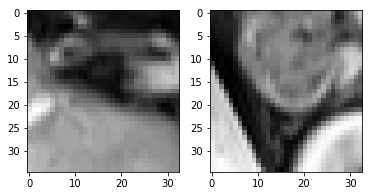

In [217]:
# can be used to determine if an image is flipped
cls = "hcc"
acc_num = 'E100894274'#acc_nums[0]
img_fn = acc_num + ".npy"
img = np.load(C.full_img_dir+"\\"+cls + "\\"+img_fn)
hf.plot_slice_flips(img, voi_df_art[(voi_df_art["Filename"] == img_fn) & (voi_df_art["cls"] == cls)].iloc[0], flipz="both", pad=10)
print(np.amin(img), np.amax(img), np.mean(img))
#hf.plot_section_auto(img)

for cls in C.classes_to_include:
    for fn in os.listdir(os.path.join(C.crops_dir, cls)):
        img = np.load(os.path.join(C.crops_dir, cls, fn))
        if np.amin(img) < -2:
            vm.reload_accnum(fn[:fn.find('_')], cls, augment=True, overwrite=True)

-0.9845335179109991 0.653689980210409 -0.1433195712619333


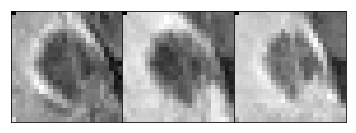

In [56]:
# Cropped, rescaled or augmented imgs
img = drm.plot_check(2, "12324408_0", normalize=[-1,0])
print(np.amin(img), np.amax(img), np.mean(img))

In [46]:
vm.save_vois_as_imgs("hemangioma", save_dir="E:\\everything-small")

In [274]:
for x in voi_df_art["id"].values:
    vm.plot_multich_with_bbox(x+".npy", save_dir="E:\\everything-small")

C:\Users\Clinton\AppData\Local\conda\conda\envs\medical-env\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [ ]:
cbuild._plot_multich_with_bbox("E102095465_0.npy", save_dir="E:\\everything")

In [45]:
import importlib
importlib.reload(cbuild)

<module 'cnn_builder' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\python\\cnn_builder.py'>

## Run CNN

In [104]:
voi_df_art[voi_df_art['id'].str.contains('4340_0')]

,Filename,x1,x2,y1,y2,z1,z2,cls,flipz,real_dx,real_dy,real_dz,id,lesion_num


In [ ]:
import cnn_builder as cbuild
importlib.reload(cbuild)
cbuild.overnight_run(C)

# Situational

In [76]:
df = pd.read_excel(xls_name, sheetname)
df = drm.preprocess_df(df, C)
acc_nums = list(set(df['Patient E Number'].dropna().astype(str).tolist()))

In [ ]:
for img_fn in sorted(set(voi_df[voi_df["cls"] == "cyst"]['Filename'])):
    img = np.load("full_imgs\\"+img_fn)
    if np.sum(img[img.shape[0]*1//5:img.shape[0]*4//5,img.shape[1]//5:img.shape[1]*2//5,:img.shape[2]//3]) > \
            np.sum(img[img.shape[0]*1//5:img.shape[0]*4//5,img.shape[1]//5:img.shape[1]*2//5,(img.shape[2]+1)*2//3:]):
        print(img_fn)

for cls in os.listdir(C.aug_dir):#classes_to_include:
    for img_fn in os.listdir(C.aug_dir + cls):
        if "refl" in img_fn:
            os.remove(C.aug_dir + cls + "\\" + img_fn)

img = img * 2 - 1

for cls in C.classes_to_include:
    fns = os.listdir(C.crops_dir + cls)
    for fn in fns:
        img = np.load(C.crops_dir + cls + "\\" + fn)
        img = img * 2 - 1
        np.save(C.crops_dir + cls + "\\" + fn, img)

for cls in C.classes_to_include:
    fns = os.listdir(C.orig_dir + cls)
    for fn in fns:
        img = np.load(C.orig_dir + cls + "\\" + fn)
        img = img * 2 - 1
        np.save(C.orig_dir + cls + "\\" + fn, img)

for cls in C.classes_to_include:
    fns = os.listdir(C.aug_dir + cls)
    for fn in fns:
        img = np.load(C.aug_dir + cls + "\\" + fn)
        img = img * 2 - 1
        np.save(C.aug_dir + cls + "\\" + fn, img)

for cls in os.listdir(C.aug_dir):#classes_to_include:
    for img_fn in os.listdir(C.aug_dir + cls):
        if "refl" not in img_fn:
            img = np.load(C.aug_dir + cls + "\\" + img_fn)
            aug_img = tr.generate_reflected_img(img)
            np.save(C.aug_dir + cls + "\\" + img_fn[:-4] + "-refl", aug_img)